## Parameters
Golovin Kernel, A = 1e-4 cm3/sec

**Collocation**
```
    # Numerical parameters
    FT = Float64
    tspan = (0.0, 4*3600.0)

    # basis setup 
    Nb = 16
    rmax  = 200.0
    rmin  = 2.0
    vmin = 4/3*pi*rmin^3
    vmax = 4/3*pi*rmax^3

    r_cutoff = 25
    v_cutoff = 4/3*pi*r_cutoff^3

    # Physical parameters: Kernel
    a = 1e-4
    b = 0.0
    c = 0.0    
    r = v->(3/4/pi*v)^(1/3)
    area = v->4*pi*r(v)^2
    kernel_func = x -> a + b*(x[1]+x[2]) + c*(r(x[1])+r(x[2]))^2*abs(area(x[1])-area(x[2]))
    tracked_moments = [1.0]
    inject_rate = 0
    N     = 100           # initial droplet density: number per cm^3
    θ_v   = 1000          # volume scale factor: µm^3
    θ_r   = 3             # radius scale factor: µm
    k     = 3             # shape factor for particle size distribution 
    ρ_w   = 1.0e-12       # density of droplets: 1 g/µm^3
```

**Bott**
```
Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
[7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-12, 3, 1000, 100]
gmin = 1e-10
```

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.n_part = 100 / si.cm**3
        self.k = 3
        self.theta = 1000 * si.um**3
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 3600.0, 14400.0]
        self.kernel = ConstantK(a=1e-4 * si.cm**3 / si.s)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Gamma(norm_factor=self.norm_factor, theta=self.theta, k=self.k)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

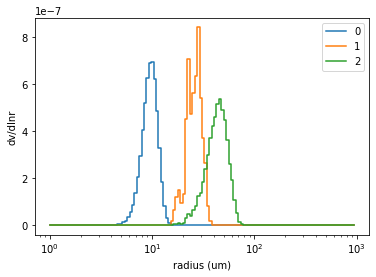

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


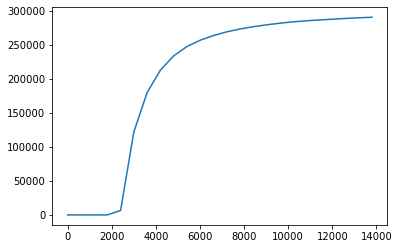

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# constK_IC1
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [14400, 32, 1.0, 1, 7.091336e-10, 1e-09, 0.0001, 3, 1000, 100]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [1.91825611e-007, 3.06594679e-006, 4.89508996e-005, 7.79889052e-004,
 1.23724906e-002, 1.94619238e-001, 3.00969894e+000, 4.49860279e+001,
 6.28155044e+002, 7.65464890e+003, 7.10431387e+004, 3.82468690e+005,
 6.92824760e+005, 1.42088340e+005, 3.73515426e+002, 1.61320203e-004,
 1.88074197e-018, 1.59768126e-047, 7.20596272e-107, 9.16169370e-227,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr36 = [4.32771256e-10, 6.91697859e-09, 1.10436465e-07, 1.75948125e-06,
 2.79131577e-05, 4.39074012e-04, 6.79009830e-03, 1.01493714e-01,
 1.41742127e+00, 1.72969587e+01, 1.64123880e+02, 1.06521403e+03,
 4.91049003e+03, 1.90057164e+04, 6.85986108e+04, 2.08442501e+05,
 4.32761771e+05, 4.27194968e+05, 1.27613308e+05, 7.30433398e+03,
 4.95637629e+01, 2.75624208e-02, 1.36393300e-06, 6.75313288e-12,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr144 = [9.99916635e-11, 4.24156132e-10, 6.77207586e-09, 1.07893172e-07,
 1.71166310e-06, 2.69244634e-05, 4.16375743e-04, 6.22370210e-03,
 8.69182638e-02, 1.06072508e+00, 1.00716702e+01, 6.56924924e+01,
 3.09097958e+02, 1.26171028e+03, 5.10677698e+03, 1.99590052e+04,
 7.19246591e+04, 2.16424047e+05, 4.39828744e+05, 4.17903619e+05,
 1.18025031e+05, 6.27105605e+03, 3.87669058e+01, 1.95205468e-02,
 8.84770217e-07, 4.04534449e-12, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,
  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,
  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
  3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,  4400.,
  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,
  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
  6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
  7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,  8900.,
  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,  9700.,  9800.,
  9900., 10000., 10100., 10200., 10300., 10400., 10500., 10600., 10700.,
 10800., 10900., 11000., 11100., 11200., 11300., 11400., 11500., 11600.,
 11700., 11800., 11900., 12000., 12100., 12200., 12300., 12400., 12500.,
 12600., 12700., 12800., 12900., 13000., 13100., 13200., 13300., 13400.,
 13500., 13600., 13700., 13800., 13900., 14000., 14100., 14200., 14300.,
 14400.]
M0_bott = [100.01643568,  68.1622868 ,  51.54853044,  41.40125394,  34.57258949,
  29.66790008,  25.97657013,  23.09899836,  20.79339902,  18.90498546,
  17.33012193,  15.99683331,  14.85358438,  13.86251016,  12.99516767,
  12.2297786 ,  11.54938666,  10.94059413,  10.39267575,   9.89694466,
   9.44629057,   9.03483796,   8.65768931,   8.3107299 ,   7.99047746,
   7.6939652 ,   7.41864981,   7.16233856,   6.9231309 ,   6.69937136,
   6.48961129,   6.29257758,   6.10714683,   5.93232401,   5.76722463,
   5.61105981,   5.46312373,   5.32278297,   5.18946745,   5.06266276,
   4.94190349,   4.82676753,   4.71687119,   4.61186488,   4.51142944,
   4.4152729 ,   4.32312761,   4.2347478 ,   4.14990738,   4.06839798,
   3.99002729,   3.91461751,   3.84200402,   3.77203417,   3.70456624,
   3.63946844,   3.57661808,   3.51590079,   3.45720983,   3.40044547,
   3.3455144 ,   3.29232924,   3.24080809,   3.19087408,   3.142455  ,
   3.09548296,   3.04989406,   3.0056281 ,   2.96262834,   2.92084122,
   2.88021617,   2.84070539,   2.80226366,   2.76484817,   2.72841839,
   2.69293586,   2.65836413,   2.62466857,   2.5918163 ,   2.55977604,
   2.52851808,   2.4980141 ,   2.46823715,   2.43916156,   2.41076283,
   2.3830176 ,   2.35590357,   2.32939946,   2.30348491,   2.27814047,
   2.25334753,   2.2290883 ,   2.20534572,   2.18210346,   2.15934588,
   2.13705798,   2.11522537,   2.09383423,   2.07287133,   2.05232392,
   2.03217978,   2.01242715,   1.99305474,   1.97405167,   1.95540748,
   1.9371121 ,   1.91915584,   1.90152935,   1.88422364,   1.86723003,
   1.85054016,   1.83414594,   1.81803961,   1.80221365,   1.78666079,
   1.77137403,   1.7563466 ,   1.74157196,   1.72704378,   1.71275595,
   1.69870256,   1.68487788,   1.67127637,   1.65789268,   1.64472162,
   1.63175815,   1.61899741,   1.60643469,   1.5940654 ,   1.58188512,
   1.56988954,   1.55807451,   1.54643596,   1.53496998,   1.52367276,
   1.5125406 ,   1.50156991,   1.4907572 ,   1.48009908,   1.46959227,
   1.45923356,   1.44901984,   1.43894809,   1.42901537,   1.41921882]
M1_bott = [299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085183, 299700.54085183, 299700.54085183, 299700.54085183,
 299700.54085183, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085184, 299700.54085184, 299700.54085184, 299700.54085184,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085185,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085185,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085185,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085185, 299700.54085186, 299700.54085186, 299700.54085185,
 299700.54085185, 299700.54085185, 299700.54085185, 299700.54085185,
 299700.54085185, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085186, 299700.54085185, 299700.54085185, 299700.54085186,
 299700.54085186, 299700.54085185, 299700.54085185, 299700.54085185,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085186, 299700.54085186, 299700.54085186, 299700.54085186,
 299700.54085187, 299700.54085187, 299700.54085187, 299700.54085187,
 299700.54085187, 299700.54085187, 299700.54085187, 299700.54085188,
 299700.54085188]
M2_bott = [1.19640534e+09, 2.02661222e+09, 2.87109924e+09, 3.72002207e+09,
 4.57111474e+09, 5.42330132e+09, 6.27616769e+09, 7.12953043e+09,
 7.98323086e+09, 8.83712977e+09, 9.69113735e+09, 1.05452155e+10,
 1.13993587e+10, 1.22535727e+10, 1.31078595e+10, 1.39622131e+10,
 1.48166193e+10, 1.56710604e+10, 1.65255185e+10, 1.73799789e+10,
 1.82344319e+10, 1.90888726e+10, 1.99433006e+10, 2.07977189e+10,
 2.16521324e+10, 2.25065469e+10, 2.33609680e+10, 2.42154003e+10,
 2.50698472e+10, 2.59243104e+10, 2.67787903e+10, 2.76332859e+10,
 2.84877951e+10, 2.93423149e+10, 3.01968421e+10, 3.10513731e+10,
 3.19059045e+10, 3.27604329e+10, 3.36149557e+10, 3.44694704e+10,
 3.53239754e+10, 3.61784696e+10, 3.70329522e+10, 3.78874234e+10,
 3.87418834e+10, 3.95963333e+10, 4.04507741e+10, 4.13052072e+10,
 4.21596342e+10, 4.30140568e+10, 4.38684767e+10, 4.47228956e+10,
 4.55773150e+10, 4.64317364e+10, 4.72861611e+10, 4.81405903e+10,
 4.89950249e+10, 4.98494657e+10, 5.07039131e+10, 5.15583675e+10,
 5.24128291e+10, 5.32672977e+10, 5.41217733e+10, 5.49762554e+10,
 5.58307436e+10, 5.66852374e+10, 5.75397359e+10, 5.83942385e+10,
 5.92487443e+10, 6.01032527e+10, 6.09577626e+10, 6.18122732e+10,
 6.26667838e+10, 6.35212936e+10, 6.43758016e+10, 6.52303073e+10,
 6.60848100e+10, 6.69393090e+10, 6.77938039e+10, 6.86482941e+10,
 6.95027793e+10, 7.03572591e+10, 7.12117333e+10, 7.20662017e+10,
 7.29206642e+10, 7.37751207e+10, 7.46295712e+10, 7.54840160e+10,
 7.63384549e+10, 7.71928884e+10, 7.80473165e+10, 7.89017396e+10,
 7.97561579e+10, 8.06105719e+10, 8.14649818e+10, 8.23193881e+10,
 8.31737912e+10, 8.40281914e+10, 8.48825893e+10, 8.57369853e+10,
 8.65913797e+10, 8.74457731e+10, 8.83001658e+10, 8.91545583e+10,
 9.00089510e+10, 9.08633441e+10, 9.17177382e+10, 9.25721336e+10,
 9.34265306e+10, 9.42809295e+10, 9.51353305e+10, 9.59897340e+10,
 9.68441402e+10, 9.76985493e+10, 9.85529614e+10, 9.94073768e+10,
 1.00261796e+11, 1.01116218e+11, 1.01970643e+11, 1.02825073e+11,
 1.03679506e+11, 1.04533942e+11, 1.05388383e+11, 1.06242827e+11,
 1.07097274e+11, 1.07951725e+11, 1.08806179e+11, 1.09660637e+11,
 1.10515098e+11, 1.11369562e+11, 1.12224028e+11, 1.13078498e+11,
 1.13932970e+11, 1.14787444e+11, 1.15641920e+11, 1.16496399e+11,
 1.17350879e+11, 1.18205361e+11, 1.19059844e+11, 1.19914329e+11,
 1.20768814e+11, 1.21623300e+11, 1.22477787e+11, 1.23332274e+11,
 1.24186761e+11]
mprecip_bin = [3.69142754e-48, 2.05226485e-03, 2.91356601e-01, 4.99356191e+00,
 3.35071358e+01, 1.32911907e+02, 3.78844147e+02, 8.63727003e+02,
 1.68014276e+03, 2.90664028e+03, 4.59919539e+03, 6.78831023e+03,
 9.48026575e+03, 1.26607960e+04, 1.62997708e+04, 2.03559351e+04,
 2.47811618e+04, 2.95239745e+04, 3.45322850e+04, 3.97554013e+04,
 4.51454075e+04, 5.06580365e+04, 5.62531490e+04, 6.18949208e+04,
 6.75518211e+04, 7.31964493e+04, 7.88052817e+04, 8.43583653e+04,
 8.98389882e+04, 9.52333440e+04, 1.00530206e+05, 1.05720616e+05,
 1.10797598e+05, 1.15755896e+05, 1.20591731e+05, 1.25302593e+05,
 1.29887048e+05, 1.34344575e+05, 1.38675415e+05, 1.42880444e+05,
 1.46961065e+05, 1.50919109e+05, 1.54756753e+05, 1.58476448e+05,
 1.62080859e+05, 1.65572815e+05, 1.68955259e+05, 1.72231218e+05,
 1.75403766e+05, 1.78476001e+05, 1.81451022e+05, 1.84331910e+05,
 1.87121715e+05, 1.89823441e+05, 1.92440041e+05, 1.94974403e+05,
 1.97429350e+05, 1.99807632e+05, 2.02111923e+05, 2.04344819e+05,
 2.06508839e+05, 2.08606420e+05, 2.10639920e+05, 2.12611616e+05,
 2.14523708e+05, 2.16378319e+05, 2.18177495e+05, 2.19923208e+05,
 2.21617355e+05, 2.23261767e+05, 2.24858203e+05, 2.26408356e+05,
 2.27913855e+05, 2.29376268e+05, 2.30797100e+05, 2.32177800e+05,
 2.33519760e+05, 2.34824320e+05, 2.36092767e+05, 2.37326337e+05,
 2.38526220e+05, 2.39693559e+05, 2.40829454e+05, 2.41934960e+05,
 2.43011094e+05, 2.44058833e+05, 2.45079116e+05, 2.46072846e+05,
 2.47040893e+05, 2.47984092e+05, 2.48903247e+05, 2.49799133e+05,
 2.50672493e+05, 2.51524045e+05, 2.52354479e+05, 2.53164458e+05,
 2.53954623e+05, 2.54725589e+05, 2.55477950e+05, 2.56212277e+05,
 2.56929122e+05, 2.57629014e+05, 2.58312467e+05, 2.58979972e+05,
 2.59632006e+05, 2.60269027e+05, 2.60891479e+05, 2.61499787e+05,
 2.62094365e+05, 2.62675608e+05, 2.63243902e+05, 2.63799617e+05,
 2.64343111e+05, 2.64874729e+05, 2.65394804e+05, 2.65903661e+05,
 2.66401610e+05, 2.66888952e+05, 2.67365979e+05, 2.67832973e+05,
 2.68290205e+05, 2.68737939e+05, 2.69176430e+05, 2.69605925e+05,
 2.70026661e+05, 2.70438871e+05, 2.70842776e+05, 2.71238595e+05,
 2.71626536e+05, 2.72006802e+05, 2.72379591e+05, 2.72745092e+05,
 2.73103491e+05, 2.73454965e+05, 2.73799690e+05, 2.74137832e+05,
 2.74469556e+05, 2.74795018e+05, 2.75114373e+05, 2.75427770e+05,
 2.75735353e+05, 2.76037261e+05, 2.76333632e+05, 2.76624597e+05,
 2.76910285e+05]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr144) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.003994750416002544, 0.000484142204293201, 93.7577029429749, 0.0013755634340455564, 0.001512615712456059, 0.000574325638688573, 0.00011118887555144197, 8.936519337907398e-5]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.0, 0.03767370869090172, 0.06701047246345627, 0.9226273291539041, 0.2917147329877015, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [0.0, 0.0, 0.40695710913812794, 0.0, 23.480764484459826, 78.33204964775145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [6.85987215031428, 6.85987215031428, 1.1982929094215962, 1.198292909421597, 1.198292909421597, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962]
    c_final = [0.0, 0.0, 8.636030456435149e-5, 0.0, 0.0048538541681353116, 0.017694995322167627, 0.042324220675351375, 0.10126175259640734, 0.2243697852808341, 0.4345599572977611, 0.4709449435020424, 0.040071017524880084, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# initial N, k, theta = 100.0, 3.0, 1000.0, 
# final N, k, theta = 1.3698630085484635, 1.0092164885136186, 217000.0226075398, 
def mom_f(x):
    n = 1.3698630085484635,
    k =1.0092164885136186
    theta =217000.0226075398
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =100.0
    k =3.0
    theta =1000.0
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.29348552239370157, 0.7918657665390773, 5.775668207992834, 16.378651378844324, 31.37954431428745, 52.071101061137185, 80.17862716128596, 117.70150667476634, 167.3113457211735, 232.42458596304493, 317.20695881932244, 423.1601418909994, 542.4444962643736, 716.9970498312114, 925.213092675619, 1211.7277349606825, 1400.1303626654349, 1857.396624550849, 2268.5685458720172, 2890.991340978905, 3614.735610537098, 4606.91258433489, 5847.292912383708, 7485.560505391124, 9486.889628223897, 11166.747717635957, 14400.0]
col_8_M_0 = [93.76374670027026, 93.64444698653257, 93.44791118865085, 91.52427653548763, 87.66890076106785, 82.70569888313823, 76.66031202397632, 69.65031852741312, 61.9500704952886, 53.888685800056344, 45.83502535174251, 38.16031897585379, 31.360595563021175, 25.969362902713172, 20.602261801453054, 16.413958009808237, 13.156647848223447, 11.705638097134512, 9.233532167239614, 7.752032853207262, 6.220341555534732, 5.037733975788188, 3.9733836275839427, 3.1224951687648255, 2.416703179965252, 1.937814414867707, 1.6707719678779647, 1.319026243260997]
col_8_M_1 = [299998.64608824207, 301670.94957129355, 303244.83870878833, 318455.62711118633, 347815.8117024922, 383154.02935659816, 421887.7922493755, 459808.2963771048, 491087.6014510633, 509808.26128617645, 511335.59509044496, 493904.25637708546, 460615.6898940643, 420740.34719648503, 367843.40680284356, 316487.48111866077, 370658.7202642126, 416330.15970223513, 480809.493536214, 502443.3265141007, 501225.1669918783, 476985.66107333516, 432697.84313699265, 379062.2014777677, 320623.2261772517, 381533.1177740642, 438377.9960592765, 498458.8882540674]
col_8_M_2 = [2.9874729152896313e10, 4.440112344219244e10, 4.4543788041381035e10, 4.5926121075443535e10, 4.8616421536601845e10, 5.190894323808601e10, 5.562934819819746e10, 5.948898027269524e10, 6.307850719333364e10, 6.59880024532587e10, 6.7889723807485016e10, 6.863010006651132e10, 6.830149022409472e10, 6.731646583575305e10, 6.564637213316726e10, 6.3834392314054016e10, 6.999748632190082e10, 1.042292478039372e11, 1.577671884367157e11, 1.8228017762260962e11, 1.9627052166175632e11, 1.954919521300133e11, 1.8341031260269714e11, 1.6441474181093054e11, 1.4145923170013754e11, 5.2053703324148584e11, 8.295095033897999e11, 1.1976572206621023e12]

col_16_times = [0.0, 0.1646411460070747, 0.41118338466028725, 1.2822700054632752, 6.326335722185398, 11.306453073779725, 26.289552449376377, 44.41896902394563, 68.74243984000164, 98.0729343527623, 132.9038326118971, 177.67055568522733, 209.75822906408172, 282.55965972005373, 353.8734879487029, 439.88590939355856, 559.457067590301, 690.9047893126045, 896.1101791376915, 1094.5372493697669, 1446.4055570572073, 1783.626257914819, 2030.2676916283604, 2489.730085524534, 3032.8989494673224, 3873.0891257769217, 4758.732474706212, 5399.322576477893, 6742.468294075015, 8057.953945564421, 10397.63736691573, 12585.594690797172, 14322.081256548709, 14400.0]
col_16_M_0 = [102.21977123280972, 102.13587497782147, 102.01873193833939, 101.60736164841595, 99.27535240436025, 97.05213791720989, 90.80352816972771, 84.03773193562566, 76.13366147479252, 68.08714637440644, 60.21446998666987, 52.806942484819096, 48.729597293535036, 41.41248463661315, 36.01163331876669, 31.006232500486863, 25.83691825901192, 22.09512535193648, 18.01783999070454, 15.254919280355265, 11.916328973187824, 9.844344117037265, 8.783086998355582, 7.309961003332296, 6.08686148760536, 4.8079734802255505, 3.9257936966100373, 3.4891803915436768, 2.827570294412775, 2.37972018739572, 1.8453315158156156, 1.5193356378015683, 1.3431210707759116, 1.3361668865605174]
col_16_M_1 = [336301.50776646635, 336449.8936950547, 336767.18327427615, 337869.80595959444, 343714.1537526587, 348634.8795399803, 359044.55022889975, 364652.4936508619, 363899.61923105083, 355331.07699771377, 339665.4655744374, 338535.27093276044, 345257.98444151133, 353206.6959570678, 352344.06882520573, 343584.6006806266, 324122.9840128353, 334275.5548192391, 343638.9837489629, 343298.0235226925, 328038.6525228041, 318882.70636071276, 326080.19239750865, 333812.40107230184, 333697.2862661412, 320399.9841556044, 307071.01792423177, 314437.3027877823, 323144.99789199233, 323022.62560493284, 309070.84717023553, 294104.8154420181, 301782.7629344029, 302080.3931451972]
col_16_M_2 = [1.5621549151932182e9, 1.5676215538851779e9, 1.577121187526006e9, 1.610329417389213e9, 1.7924651339781609e9, 1.9561804662546248e9, 2.36358209729946e9, 2.7162866919915457e9, 3.012669247806631e9, 3.189298754550109e9, 3.2440732987536664e9, 3.9654238976832643e9, 4.723848637843665e9, 6.070251686045382e9, 6.91221283757148e9, 7.4524744464536915e9, 7.658722206358798e9, 1.0613391916268559e10, 1.4347647852717154e10, 1.6660304828275764e10, 1.8447259466879166e10, 2.151901442637716e10, 2.6717810268201843e10, 3.4572176063369705e10, 4.0640177580207054e10, 4.485970801511771e10, 5.009292295409057e10, 6.304110588611711e10, 8.476069865469054e10, 9.850398690409357e10, 1.0932187384377922e11, 1.1759315311897865e11, 1.506652779564199e11, 1.5205866298464148e11]


In [13]:
t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [2421.099480092278, 130207.45943644276, 150264.11249731967, 144714.5559634666, 133335.331500019, 121537.88325020825, 110790.22912786841, 111421.92576647592, 175526.38501752994, 228329.68908527808, 271413.87190667837, 306263.9094992749, 334196.7179844122, 356349.65525882464, 373687.93743531185, 387023.2636215996, 397036.44522297947, 404293.4829352869, 409263.4396363919, 412343.3988747851, 413861.61625669623, 414089.52494037326, 413252.8570580335, 411542.3224153423, 409119.30167707254, 406115.96182221465, 402643.24504559045, 398792.38190217275, 394640.3670926805, 390253.97773139074, 385689.7733461394, 380994.0958783206, 376203.4478770982, 371350.5268968068, 366461.3622402236, 361557.77024530794, 356658.79067816, 351780.68673301896, 346936.9450322656, 342138.27562642004, 337392.6119941427, 332706.26389830705, 328085.434059566, 323533.9125989231, 319054.88386684615, 314650.9882256984, 310324.32204973727, 306076.4377251148, 301908.3436498779, 297820.50423396745, 293812.8398992194, 289884.7270793643, 286035.52613025525, 282264.4595634642, 278565.9077330811, 280716.0964145983, 289204.1375412871, 297464.9399883832, 305498.836248723, 313306.94486245175, 320891.1704170193, 328254.20354718214, 335399.52093500446, 342331.3853098564, 349054.84544841596, 355575.7361746658, 361899.4763939389, 368029.00069965154, 373968.4858906446, 379722.1386447606, 385294.1219396709, 390688.555052874, 395909.5135616983, 400961.02934329846, 405847.0905746581, 410571.64173258864, 415138.58359372965, 419551.77321816434, 423815.0053731267, 427931.97499688505, 431906.30467548466, 435741.55049412954, 439441.2020371893, 443008.6823881947, 446447.3481298359, 449760.48934397055, 452951.32961161446, 456023.026012948, 458978.6691273126, 461821.2830332116, 464553.82530831214, 467179.1870294425, 469700.19277259364, 472119.60061291826, 474440.1021247322, 476664.322381512, 478794.8199558995, 480834.08691969595, 482784.5488438648, 484648.56479853374]
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [0.0, 0.0, 4631.5699176761145, 7080.9706411721445, 11448.168597433849, 37991.95525011256, 60853.723659663134, 78740.43848661437, 91931.6144865557, 101207.62822038466, 107397.19720909288, 111232.59541609845, 122987.34654716156, 139443.99130620644, 154470.98252542806, 167986.05189200043, 179983.3460971245, 190504.80350638804, 199628.52869232057, 207451.3829494613, 214078.27213776082, 219616.9824871719, 224174.77597753267, 227853.6964338724, 230749.21619719008, 232949.49338483595, 234535.37189051148, 235579.72644665831, 236145.71620633625, 236299.12908624473, 236095.39032224406, 235576.70133825185, 239127.41272138339, 243773.5483851523, 248179.69614280306, 252352.68625691262, 256293.8334186718, 260005.53051579508, 263491.0093295301, 266754.43837621633, 269800.8922510088, 272635.7503259621, 275264.6913560348, 277693.69347908965, 279929.0342158936, 281977.2904701176, 283845.33852833684, 285540.1978382474, 287068.50804452586, 288437.1219267802, 289652.8050971271, 290722.1978564676, 291651.8151944869, 292448.0467896543, 293117.15700922353, 293665.28490923234, 294098.440696822, 294422.40549791465, 294642.6980473008, 294764.65263763204, 294793.4225772533, 294733.9801902034, 294591.11681621446, 294369.4428107125, 294073.38754481694, 293707.1994053406, 293274.94579479034, 292780.5131313663, 292227.60684896226, 291619.75139716547, 290960.29024125705, 290252.3858622116, 289498.6169885885, 288700.2137034809, 287861.0581433519, 286985.03702273266, 286075.61239252106, 285135.8216399815, 284168.27748874534, 283175.16799881076, 282158.25656654243, 281118.88192467194, 280057.9581422976, 278975.9746248845, 277872.99611426436, 278667.22479869635, 279679.8988100643, 280670.54407136294, 281642.20462344604, 282595.5689214973, 283530.2715722254, 284445.97853436903, 285342.3871186973, 286219.22598800954, 287076.25515713537, 287913.265992935, 288730.08121429855, 289526.5548921466, 290302.57244943007, 291058.0474329776]


In [14]:
t_cloudy = [0.0, 0.0286413768802432, 0.3150551456826752, 2.7983149439938084, 7.597212770530456, 13.543287575224783, 20.934412617648626, 29.64220272479821, 39.75897579342765, 51.23119035675511, 64.08245607864396, 78.29878911347626, 93.89633342377543, 110.88887161194927, 129.30689336784167, 149.18792695109076, 170.58148074370564, 193.54704572321336, 218.15449664102874, 244.48319110988012, 272.62251291018896, 302.67146242943716, 334.7388597064016, 368.94338515935056, 405.4138439164665, 444.28944519240645, 485.7202036651938, 529.8674083802908, 576.9041733349522, 627.0160818614764, 680.4018737424734, 737.2742688443602, 797.8608004751823, 862.4048182074221, 931.1664824920184, 1004.4239654363254, 1082.474618864392, 1165.6363802351102, 1254.2491815656988, 1348.67654832424, 1449.3072910019023, 1556.5573784219064, 1670.8719120733165, 1792.7273155622256, 1922.6336488691197, 2061.137227527371, 2208.8232880931523, 2366.3190937303593, 2534.297116811429, 2713.4786366370786, 2904.6375684781506, 3108.6046921607995, 3326.2722166789786, 3558.598766449969, 3806.61481795046, 4071.4287253618127, 4354.2332033772, 4656.312387064536, 4979.0497262912795, 5323.93658756875, 5692.58148936118, 6086.720617788346, 6508.229018880465, 6959.133187408144, 7441.624786860822, 7958.075798590117, 8511.055232763623, 9103.347579528583, 9737.973426244225, 10418.211743436557, 11147.62515585348, 11930.08747597895, 12769.814680219064, 13671.398928237557, 14400.0]
M0_cloudy = [100.0, 99.98568136208729, 99.8427201862306, 98.62014881889591, 96.34040714272825, 93.65782566687709, 90.52460304055312, 87.0920055776935, 83.41710643017412, 79.60794984992035, 75.73392152449033, 71.86520671221831, 68.05120628049663, 64.33166909898098, 60.733620894896646, 57.27574890619322, 53.96923772490693, 50.81984543866574, 47.82921193733668, 44.99607735078733, 42.317070194152535, 39.78741893011684, 37.40143380725269, 35.1528826814047, 33.03525394575076, 31.04194897224572, 29.166415075503807, 27.402237530583403, 25.743200745978818, 24.18332670580244, 22.716898610666235, 21.33847132145766, 20.042875819927364, 18.825215934606437, 17.680863449642317, 16.605448490355037, 15.594850632586004, 14.645186971607068, 13.752801362811493, 12.914252591940818, 12.126303108825738, 11.38590767248817, 10.6902027898181, 10.036496202561864, 9.422257179152313, 8.84510674297432, 8.30280919231923, 7.79326319505668, 7.314494104418698, 6.864646230680752, 6.441975818539626, 6.044844277992624, 5.671711913443872, 5.32113199192071, 4.991745163676146, 4.682274111329296, 4.39151866946045, 4.118351238918652, 3.8617123199207963, 3.6206063942925906, 3.394098183152521, 3.1813088792791406, 2.9814128381160883, 2.793634311367101, 2.617244455577424, 2.451558503573402, 2.2959331048703775, 2.1497638248078856, 2.01248274726276, 1.883556339917692, 1.7624833174930918, 1.6487927271385268, 1.5420420784250335, 1.4418156425523787, 1.3698630085484633]
M1_cloudy = [300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0]
M2_cloudy = [1.2e9, 1.2002577723919258e9, 1.2028354963111842e9, 1.2251848344963071e9, 1.268374914935794e9, 1.3218895881789205e9, 1.3884097135619276e9, 1.4667798245278304e9, 1.5578307821475208e9, 1.6610807132200644e9, 1.7767421047203755e9, 1.9046891020380592e9, 2.045067000836038e9, 2.1979998445362377e9, 2.3637620403475685e9, 2.542691342607159e9, 2.735233326753561e9, 2.9419234115850925e9, 3.1633904698651886e9, 3.4003487201092567e9, 3.6536026163421307e9, 3.924043162052416e9, 4.212649737590645e9, 4.520490466723107e9, 4.848724595605728e9, 5.198605007173194e9, 5.571481833531083e9, 5.968806676092651e9, 6.392137560838164e9, 6.843144737764346e9, 7.32361686492202e9, 7.83546842111784e9, 8.380747206135018e9, 8.96164336613901e9, 9.580498345204176e9, 1.0239815692316017e10, 1.0942271573914412e10, 1.1690727427157831e10, 1.2488242640235756e10, 1.3338088942402819e10, 1.4243765628130386e10, 1.5209016416889175e10, 1.623784722215571e10, 1.733454585647583e10, 1.850370285978444e10, 1.975023507201617e10, 2.1079409622339745e10, 2.2496871879428543e10, 2.4008674094875626e10, 2.5621307782680714e10, 2.7341738180638203e10, 2.917744230761778e10, 3.113645004509386e10, 3.3227389013466232e10, 3.545953350181031e10, 3.784285869871591e10, 4.038809903758994e10, 4.3106811735470024e10, 4.601144784290583e10, 4.91154296606294e10, 5.243323385742466e10, 5.598048611155974e10, 5.9774061841215034e10, 6.38321995041186e10, 6.817462407755708e10, 7.28226834009201e10, 7.779949857459962e10, 8.31301300208548e10, 8.88417630393906e10, 9.4963908381558e10, 1.0152862969060829e11, 1.0857079130426747e11, 1.1612833704159735e11, 1.2424259637850198e11, 1.308000070292691e11]
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [5.523858061377992e-19, 0.035630496651405906, 42.67868217614836, 793.623170934011, 3829.0121551019647, 10132.65517503173, 19518.780252375418, 31177.75600942814, 44205.05362295267, 57842.97272452134, 71537.23561327491, 84916.24124860013, 97749.36115886687, 109906.73740413376, 121327.17509606555, 131994.5470246292, 141921.2192343575, 151136.73214425438, 159680.22971933743, 167595.48916275706, 174927.72584112626, 181721.595618122, 188019.99294637266, 193863.3736555647, 199289.43069361406, 204332.9840857996, 209026.00339357127, 213397.73142984067, 217474.8324549163, 221281.58212809742, 224840.05352153972, 228170.30724505402, 231290.57188016098, 234217.41487150075, 236965.89807482483, 239549.7276633631, 241981.37715129505, 244272.21992359462, 246432.62240124407, 248472.05443932617, 250399.169488661, 252221.88249532465, 253947.4493225133, 255582.5172218986, 257133.1908255048, 258605.0833698146, 260003.3549787401, 261332.75959553683, 262597.68424771156, 263802.17460291646, 264949.9692159826, 266044.53048082406, 267089.0611407132, 268086.52949517453, 269039.69238927256, 269951.1101261789, 270823.161086252, 271658.05850072537, 272457.8668414125, 273224.5087046666, 273959.7775066436, 274665.34825736395, 275342.7889748664, 275993.5646847172, 276619.0467496938, 277220.51983771625, 277799.1907203266, 278356.19112814736, 278892.58298574854, 279409.3641898301, 279907.4743039813, 280387.79849347676, 280851.1689722709, 281298.3703452638, 281730.1420087507, 282147.18303658883, 282550.1538822431, 282939.677375857, 283316.3427935945, 283680.7070278015, 284033.2981924662, 284374.6169375954, 284705.136967037, 285025.30718703003, 285335.55357818457, 285636.28047872253, 285927.87266985094, 286210.69573249493, 286485.09643268475, 286751.40495495585, 287009.93511730724, 287260.98599864304, 287504.8429839362, 287741.77799594676, 287972.0497137284, 288195.904776081, 288413.57887418295, 288625.296961891, 288831.2740755726, 289031.7154886469]

## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


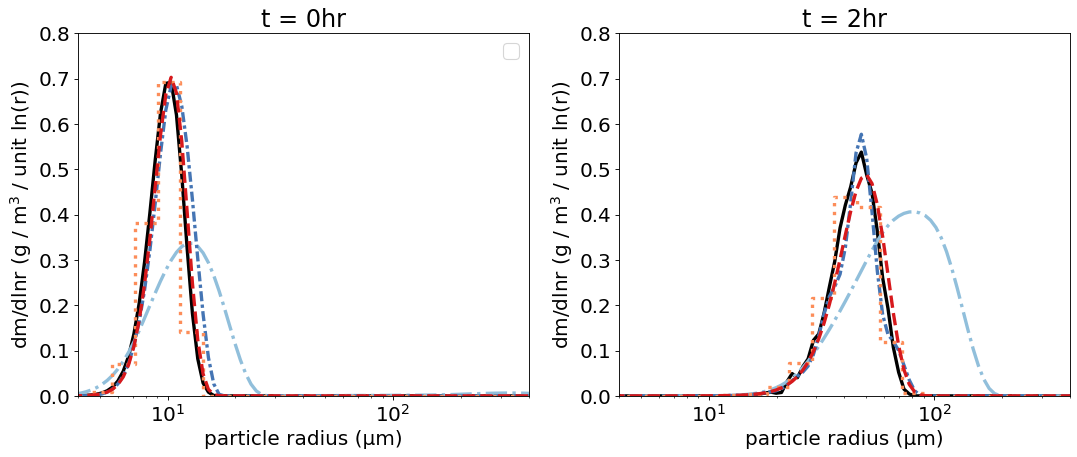

In [15]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1],linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2],linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([4.0, 400.0])
ax[1].set_xlim([4.0, 400.0])
ax[0].set_ylim([0.0, 0.8])
ax[1].set_ylim([0.0, 0.8])
ax[0].legend()

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 2hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.savefig("m(v)_constant_IC1.pdf", transparent=True)

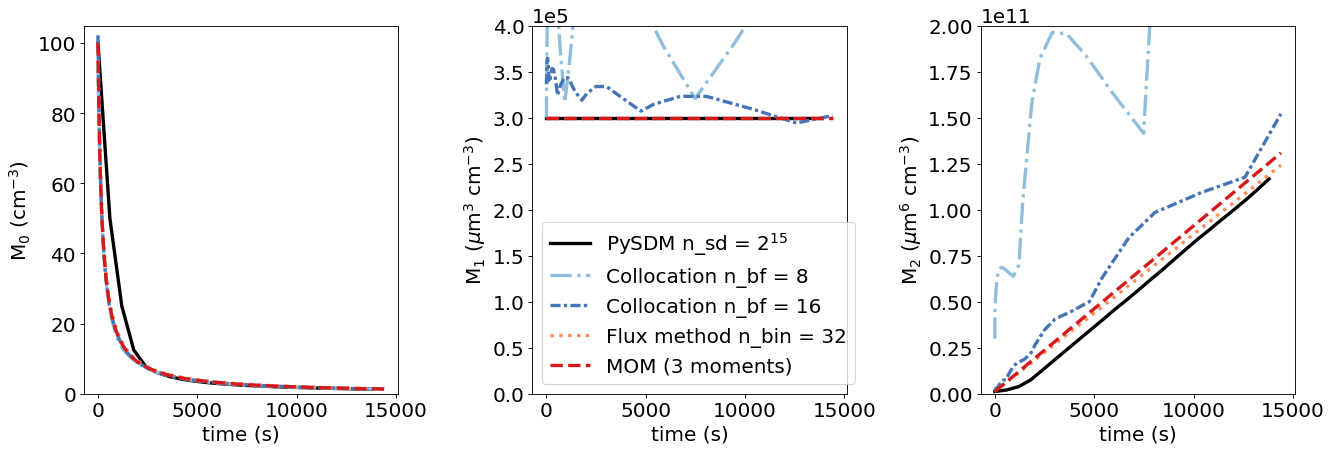

In [16]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 105])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 2e11])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_constant_IC1.pdf", transparent=True)


In [17]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

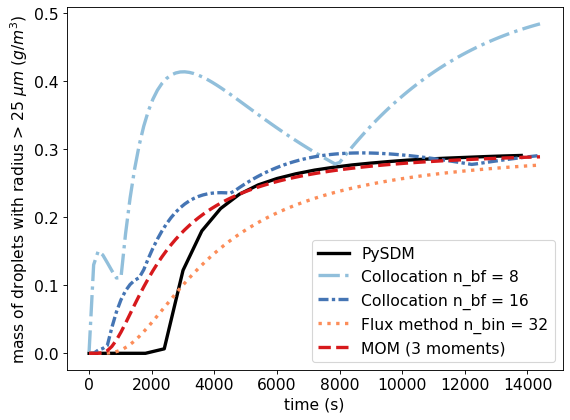

In [18]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_constant_IC1.pdf', transparent=True)

## Error Computation

In [20]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf
v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("constant_IC1_errors.pkl", "wb" ))

1.02756638642869 0.16550357038987626 0.16473772842891188 0.249602497319754
